In [14]:
from pprint import pprint

In [1]:
from langgraph.graph import StateGraph, MessagesState, START, END

def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

{'messages': [HumanMessage(content='hi!', additional_kwargs={}, response_metadata={}, id='6c0746dc-9dfe-4c8f-9c77-e232d086da45'),
  AIMessage(content='hello world', additional_kwargs={}, response_metadata={}, id='bcd24c09-c18a-4063-8928-93eb74a9f290')]}

- Graph API: node와 edge를 이용하여 graph 형태로 Agent를 생성한다.
- Functional API: 단일 fucntion으로의 Agent를 생성한다.

# Quickstart

In [2]:
model_name = "gpt-5.1"

In [3]:
from langchain.tools import tool
from langchain.chat_models import init_chat_model


model = init_chat_model(
    model=model_name,
    temperature=0
)


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [15]:
pprint(model_with_tools.get_graph())

Graph(nodes={'389735806a3949eb8ec5492502905be9': Node(id='389735806a3949eb8ec5492502905be9', name='ChatOpenAI', data=ChatOpenAI(profile={'max_input_tokens': 400000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x1161b6870>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x115d0fe00>, root_client=<openai.OpenAI object at 0x1160bc500>, root_async_client=<openai.AsyncOpenAI object at 0x116f68620>, model_name='gpt-5.1', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), metadata={}),
             'a7a1cdc974854142a8f25c773c476a60': Node(id='a7a1cdc974854142a8f25

In [ ]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


# graph의 state는 대화 내역이나 LLM 호출 횟수 등을 저장하는 용도로 사용된다.
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]  # operator.add와 함께 사용되는 Annotated는 대화 내역을 대체하는 게 아닌, 새로운 대화 내역을 추가할 수 있도록 해준다.
    llm_calls: int

- Annotated란?
    - 타입 힌트에 추가 메타데이터를 붙이기 위한 표준 도구. 문서 생성이나 UI 힌트 등에 활용 가능.
    - 예시
        ```
        from typing_extensions import Annotated

        Age = Annotated[int, "나이는 0 이상 100 이하"]
        ```
        - int는 타입 체크용으로 실제 타입에 해당
        - "나이는 0 이상 100 이하"는 추가 메타데이터
- operator.add란?
    - 두 개의 값을 더하는 연산자. 이 연산자는 두 개의 값을 더하는 연산을 수행하는 함수를 반환한다.
    - 예시
        ```
        from operator import add

        add(1, 2)  # 3
        ```

In [ ]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM은 tool을 호출할지 말지 결정한다."""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]  # 시스템 프롬프트에 대화 내역을 추가
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1  # 호출 횟수 1개 증가
    }

In [ ]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """tool 호출 후 결과를 반환한다."""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]  # tool_name을 이용하여 사전에 정의된 tool을 가져온다.
        observation = tool.invoke(tool_call["args"])  # tool을 호출하고 결과를 반환한다.
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))  # tool 호출 결과를 메시지로 변환하여 결과 목록에 추가한다.
    return {"messages": result}

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """LLM이 tool 호출을 했는지 여부에 따라 다음 노드를 결정한다."""

    messages = state["messages"]
    last_message = messages[-1]

    # LLM이 tool 호출을 만들었으면 tool_node로 이동하도록 "tool_node" 반환
    if last_message.tool_calls:
        return "tool_node"

    # 그렇지 않으면 대화를 종료하도록 END 반환
    return END

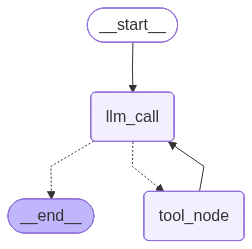

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_cXOUJ9lA17jhLgSIe75iDBGN)
 Call ID: call_cXOUJ9lA17jhLgSIe75iDBGN
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

7


In [25]:
# Build workflow
agent_builder = StateGraph[MessagesState, None, MessagesState, MessagesState](MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)  # llm_call 노드 추가
agent_builder.add_node("tool_node", tool_node)  # tool_node 노드 추가

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")  # START에서 llm_call 노드로 이동
agent_builder.add_conditional_edges(  # llm_call 노드에서 should_continue 함수를 호출하여 'tool_node' 또는 'END' 노드로 이동하도록 지정
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")  # tool_node 노드에서 llm_call 노드로 이동

# Compile the agent
agent = agent_builder.compile()  # compile 메서드는 graph를 compiled graph로 반환한다. compiled graph는 Runnable 인터페이스로 구현되어 있어, 'invoke', 'batch', 'astream' 등의 메서드를 사용할 수 있다.

# Show the agent
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
from langchain.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})  # message state를 인자로 받아, 대화 내역을 업데이트한다.
for m in messages["messages"]:
    m.pretty_print()

# Thinking in LangGraph

소비자 이메일을 처리하는 AI Agent를 만든다고 가정하자.

Agent가 해야하는 것은
- 소비자 이메일을 읽어들이고
- urgency및 topic에 대해 분류하고
- 적절한 응답을 보내고
- 복잡한 이슈에 대해 사람 직원에게 전달하며
- 필요하다면 스케쥴을 팔로우업 합니다

예시 시나리오는
1. 간단한 상품 질문: "비밀번호 어떻게 바꿔요?"
2. 버그 리포트: "PDF 형식으로 내보내기 기능에 문제 있어요"
3. 급한 청구 관련 문제: "구독료가 두번 청구됐어요"
4. 기능 요청: "모바일 앱에 다크 모드 추가해줄 수 있나요?"
5. 복잡한 기술 이슈: "API 사용했을 때, 가끔 504 오류를 반환합니다"

## Step1: 구체적인 스텝들로 워크플로우를 그려본다.

![](langgraph_review_1.png)

- 각 스텝은 node로 되어있다.
    - Read Email: 이메일 내용을 추출하고 파싱한다
    - Classify Intent: LLM을 사용하여, urgency, topic 카테고리에 대해 분류 작업을 하고, 적절한 action으로 안내한다
    - Doc Search: 관련 정보를 찾기 위해 지식 베이스에 쿼리를 날린다
    - Bug Track: tracking system에 issue를 생성하거나 업데이트한다
    - Draft Reply: 적절한 응답을 생성한다
    - Human Review: 사람 직원에게 승인 또는 도움 요청을 구한다
    - Send Reply: 이메일 응답을 보낸다

## Step 2: 각 step에 어떤 게 필요할지 정의한다
- LLM Steps: 문맥을 이해하거나 분석하거나 텍스트를 생성하거나 추론 작업을 하도록 한다
- Data Steps: 외부에 위치한 지식을 제공한다
- Action Steps: 외부 액션을 수행한다
- User Input Steps: 사람 개입이 필요할 때 사용한다

## Step 3: state를 계획한다

- state 포함 정보: steps 마다 지속되어야 하는지?
- state 미포함 정보: 외부 데이터를 가져왔다면, 처리 결과만 담을 수 있다.

In [20]:
from typing import TypedDict, Literal  # 이상하게 langgraph에서 다양한 State가 미리 정의되어 있지 않다. 대화 요약이나 공통 system prompt 같은 게 저장될 수 있을 듯한데


# Define the structure for email classification
class EmailClassification(TypedDict):
    intent: Literal["question", "bug", "billing", "feature", "complex"]
    urgency: Literal["low", "medium", "high", "critical"]
    topic: str
    summary: str

class EmailAgentState(TypedDict):
    # Raw email data
    email_content: str
    sender_email: str
    email_id: str

    # Classification result
    classification: EmailClassification | None

    # Raw search/API results
    search_results: list[str] | None  # List of raw document chunks
    customer_history: dict | None  # Raw customer data from CRM

    # Generated content
    draft_response: str | None
    messages: list[str] | None

## Step 4: 노드 Build

- 에러에 대해 적절히 대응할 수 있도록 한다
    - Transient errors(network issues, rate limit):
        - system automatic retry policy
    - LLM recoverable errors(tool failures, parsing issues)
        - llm store error in state and loop back
    - User-fixable errors(missing information, unclear instructions)
        - human pause with `interrupt()`
    - Unexpected errors
        - developer

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, RetryPolicy
from langchain_openai import ChatOpenAI
from langchain.messages import HumanMessage

llm = ChatOpenAI(model="gpt-5.1")

def read_email(state: EmailAgentState) -> dict:
    """Extract and parse email content"""
    # In production, this would connect to your email service
    return {
        "messages": [HumanMessage(content=f"Processing email: {state['email_content']}")]
    }

def classify_intent(state: EmailAgentState) -> Command[Literal["search_documentation", "human_review", "draft_response", "bug_tracking"]]:
    """Use LLM to classify email intent and urgency, then route accordingly"""

    # Create structured LLM that returns EmailClassification dict
    structured_llm = llm.with_structured_output(EmailClassification)

    # Format the prompt on-demand, not stored in state
    classification_prompt = f"""
    Analyze this customer email and classify it:

    Email: {state['email_content']}
    From: {state['sender_email']}

    Provide classification including intent, urgency, topic, and summary.
    """

    # Get structured response directly as dict
    classification = structured_llm.invoke(classification_prompt)

    # Determine next node based on classification
    if classification['intent'] == 'billing' or classification['urgency'] == 'critical':
        goto = "human_review"
    elif classification['intent'] in ['question', 'feature']:
        goto = "search_documentation"
    elif classification['intent'] == 'bug':
        goto = "bug_tracking"
    else:
        goto = "draft_response"

    # Store classification as a single dict in state
    return Command[Literal['search_documentation', 'human_review', 'draft_response', 'bug_tracking']](
        update={"classification": classification},
        goto=goto
    )

In [36]:
class SearchAPIError(Exception):
    pass


def search_documentation(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Search knowledge base for relevant information"""

    # Build search query from classification
    classification = state.get('classification', {})
    query = f"{classification.get('intent', '')} {classification.get('topic', '')}"

    try:
        # Implement your search logic here
        # Store raw search results, not formatted text
        search_results = [
            "Reset password via Settings > Security > Change Password",
            "Password must be at least 12 characters",
            "Include uppercase, lowercase, numbers, and symbols"
        ]
    except SearchAPIError as e:
        # For recoverable search errors, store error and continue
        search_results = [f"Search temporarily unavailable: {str(e)}"]

    return Command(
        update={"search_results": search_results},  # Store raw results or error
        goto="draft_response"
    )

def bug_tracking(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Create or update bug tracking ticket"""

    # Create ticket in your bug tracking system
    ticket_id = "BUG-12345"  # Would be created via API

    return Command(
        update={
            "search_results": [f"Bug ticket {ticket_id} created"],
            "current_step": "bug_tracked"
        },
        goto="draft_response"
    )

In [37]:
def draft_response(state: EmailAgentState) -> Command[Literal["human_review", "send_reply"]]:
    """Generate response using context and route based on quality"""

    classification = state.get('classification', {})

    # Format context from raw state data on-demand
    context_sections = []

    if state.get('search_results'):
        # Format search results for the prompt
        formatted_docs = "\n".join([f"- {doc}" for doc in state['search_results']])
        context_sections.append(f"Relevant documentation:\n{formatted_docs}")

    if state.get('customer_history'):
        # Format customer data for the prompt
        context_sections.append(f"Customer tier: {state['customer_history'].get('tier', 'standard')}")

    # Build the prompt with formatted context
    draft_prompt = f"""
    Draft a response to this customer email:
    {state['email_content']}

    Email intent: {classification.get('intent', 'unknown')}
    Urgency level: {classification.get('urgency', 'medium')}

    {chr(10).join(context_sections)}

    Guidelines:
    - Be professional and helpful
    - Address their specific concern
    - Use the provided documentation when relevant
    """

    response = llm.invoke(draft_prompt)

    # Determine if human review needed based on urgency and intent
    needs_review = (
        classification.get('urgency') in ['high', 'critical'] or
        classification.get('intent') == 'complex'
    )

    # Route to appropriate next node
    goto = "human_review" if needs_review else "send_reply"

    return Command(
        update={"draft_response": response.content},  # Store only the raw response
        goto=goto
    )

def human_review(state: EmailAgentState) -> Command[Literal["send_reply", END]]:
    """Pause for human review using interrupt and route based on decision"""

    classification = state.get('classification', {})

    # interrupt() must come first - any code before it will re-run on resume
    human_decision = interrupt({
        "email_id": state.get('email_id',''),
        "original_email": state.get('email_content',''),
        "draft_response": state.get('draft_response',''),
        "urgency": classification.get('urgency'),
        "intent": classification.get('intent'),
        "action": "Please review and approve/edit this response"
    })

    # Now process the human's decision
    if human_decision.get("approved"):
        return Command(
            update={"draft_response": human_decision.get("edited_response", state.get('draft_response',''))},
            goto="send_reply"
        )
    else:
        # Rejection means human will handle directly
        return Command(update={}, goto=END)

def send_reply(state: EmailAgentState) -> dict:
    """Send the email response"""
    # Integrate with email service
    print(f"Sending reply: {state['draft_response'][:100]}...")
    return {}

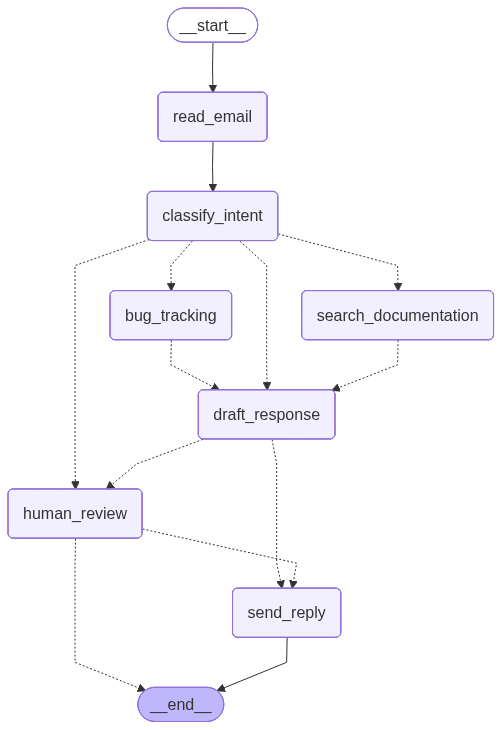

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy

# Create the graph
workflow = StateGraph[EmailAgentState, None, EmailAgentState, EmailAgentState][EmailAgentState, None, EmailAgentState, EmailAgentState](EmailAgentState)

# Add nodes with appropriate error handling
workflow.add_node("read_email", read_email)
workflow.add_node("classify_intent", classify_intent)

# Add retry policy for nodes that might have transient failures
workflow.add_node(
    "search_documentation",
    search_documentation,
    retry_policy=RetryPolicy(max_attempts=3)
)
workflow.add_node("bug_tracking", bug_tracking)
workflow.add_node("draft_response", draft_response)
workflow.add_node("human_review", human_review)
workflow.add_node("send_reply", send_reply)

# Add only the essential edges
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "classify_intent")
workflow.add_edge("send_reply", END)

# Compile with checkpointer for persistence, in case run graph with Local_Server --> Please compile without checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [41]:
from pprint import pprint


# Test with an urgent billing issue
initial_state = {
    "email_content": "I was charged twice for my subscription! This is urgent!",
    "sender_email": "customer@example.com",
    "email_id": "email_123",
    "messages": []
}

# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)
# The graph will pause at human_review

for m in result["messages"]:
    m.pretty_print()

# print(f"Draft ready for review: {result['draft_response'][:100]}...")

# When ready, provide human input to resume
from langgraph.types import Command

human_response = Command(
    resume={
        "approved": True,
        "edited_response": "We sincerely apologize for the double charge. I've initiated an immediate refund..."
    }
)

# Resume execution
final_result = app.invoke(human_response, config)
print(f"Email sent successfully!")

================================ Human Message =================================

Processing email: I was charged twice for my subscription! This is urgent!
Sending reply: We sincerely apologize for the double charge. I've initiated an immediate refund......
Email sent successfully!
